In [1]:
# Import modules
import numpy as np
import pymc3 as pm
import scipy.stats as stats
import matplotlib.pyplot as plt
from imp import reload
import utils

# Set the plot style (not necessary)
plt.style.use('seaborn-ticks')

# Remark: Running this the first time on my machine throws the following WARNINGS
# WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
# WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
# This is some compatiblity issue (I think_ between the theano and pymc3 version combined in the project and
# should not affect anything related to inference.

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


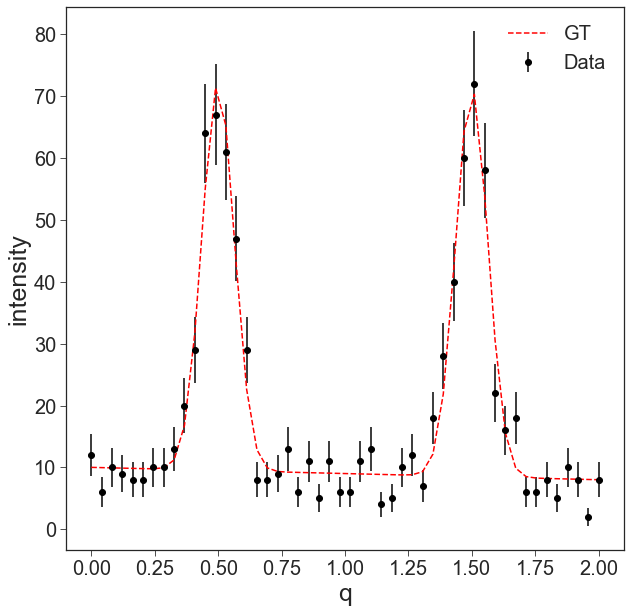

In [2]:
####################################################################################
###### 0) GENERATE ARTIFICIAL DATA
####################################################################################
# Define a ground truth (gt) paramete dictionary
p_gt_dict = {
    'mu_1': 0.5, 
    'fwhm_1': 0.15, 
    'mu_2': 1.5, 
    'fwhm_2': 0.15, 
    'rel_int_1': 0.5, 
    'sum_int': 20, 
    'bg_scale': 10, 
    'bg_slope': -0.1,
}

# Define the model function
def double_peak_model_fn(q, p_dict):
    """
    Return peak model function for a 1d input array 'q' given a certain set of
    parameters in the dictionary 'p_dict'.
    
    Args:
        q (1d-array): Array containing the q values.
        p_dict (dict: Dictionary containing the parameters as the dictionary-keys and 
            their values as the dictionary-values.
        
    Returns:
        1d-array of the model function values evaluated at each value of array q.
    """
    # To model the intensities, we use a summed intensity (sum_int=int_1+int_2) and
    # relative intensities for both peaks (rel_int_1+rel_int_2=1).
    # Determine int_1 and int_2 from the input parameters sum_int and rel_int_1
    rel_int_2 = 1.0-p_dict['rel_int_1']
    int_1     = p_dict['sum_int']*p_dict['rel_int_1']
    int_2     = p_dict['sum_int']*rel_int_2
    
    # Initialize y with contribution from first peak (using scipy.stats.norm.pdf for the peak shape)
    y = int_1*stats.norm.pdf(q, loc=p_dict['mu_1'], scale=utils.fwhm_to_sigma(p_dict['fwhm_1']))
    
    # Add contribution from second peak (using scipy.stats.norm.pdf for the peak shape)
    y += int_2*stats.norm.pdf(q, loc=p_dict['mu_2'], scale=utils.fwhm_to_sigma(p_dict['fwhm_2']))
    
    # Add contribution from background.
    # Remark: The backgound is modeled using a degree 1 polynomial in q (bg_0+bg_1*q). We implement
    #         this by reparametrizing it as bg_0*(1+bg_1/bg_0*1) calling bg_0 bg_scale and bg_1/bg_0
    #         the (unscaled) bg_slope of the polynomial
    y += p_dict['bg_scale']*(1+p_dict['bg_slope']*q)
    
    return y

# Generate some artificial data
np.random.seed(42)
# Define some q points and evaluate the ground truth model values at these q
q     = np.linspace(0, 2, 50)
y_gt  = double_peak_model_fn(q, p_gt_dict)

# Sample y from Possion distributions with mus corresponding to ground truth values
y     = stats.poisson.rvs(mu=y_gt)
# For large y, the error of this y is given by the square root
y_err = np.sqrt(y)
# Generate a data dictionary
data_dict = {'q': q, 'y': y, 'y_err': y_err, 'y_gt': y_gt}

plt.figure(figsize=(10, 10))
plt.errorbar(data_dict['q'], data_dict['y'], data_dict['y_err'], marker='o', ls='', color='k', label='Data')
plt.plot(data_dict['q'], data_dict['y_gt'], 'r--', label='GT')
plt.gca().tick_params(axis='both', labelsize=20)
plt.legend(fontsize=20)
plt.xlabel('q', fontsize=25)
plt.ylabel('intensity', fontsize=25)
plt.show()

y_model =
[10.         10.         10.         10.         10.         10.
 10.00000069 10.0001389  10.01118007 10.35724633 14.53194579 32.82419573
 55.63521508 46.22417991 21.41539291 11.42816047 10.07093442 10.00139872
 10.00001095 10.00000003 10.         10.         10.         10.
 10.         10.         10.         10.         10.         10.
 10.00000003 10.00001095 10.00139872 10.07093442 11.42816047 21.41539291
 46.22417991 55.63521508 32.82419573 14.53194579 10.35724633 10.01118007
 10.0001389  10.00000069 10.         10.         10.         10.
 10.         10.        ]
y_model.shape = (50,)

y_obs.shape = (50,)


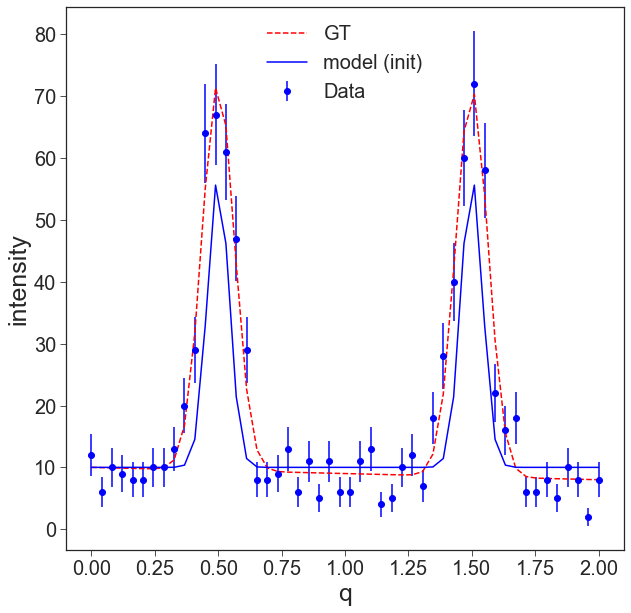

In [3]:
####################################################################################
###### 1) DEFINE THE MODEL
####################################################################################
# Remark:
# I tried to use the model definition etc. from the tutorial
# https://docs.pymc.io/en/v3/pymc-examples/examples/getting_started.html
# so that you always have the possibility to get more details.

# Define initial values for the parameters (sampling will start there).
# These are not important but they should be reasonable values.
p_dict_init = {'mu_1': 0.5, 'mu_2': 1.5}

# Define the PyMC model
with pm.Model() as double_peak_model:
    # Define the prior distributions of the model parameters.
    # This is achieved by defining each of the model parameters 
    # as a PyMC3 Random Variable corresponding to its prior.
    # Remarks: 1) This is the part where you as scientist can inject
    #             your expert knowledge about the model parameters.
    #             E.g. if mu_1 and mu_2 are known from previous experiments or theory 
    #             with a value and standard error (it will usually be implicitly Gaussian)
    #             use a normal distribution with these values for it.
    #             Here I use a rather uninformative prior to stay objective.
    #          2) We can provide an initial value using the keyword 'testval'.
    
    ##################################################################################################
    ### mu_1 and mu_2
    ##################################################################################################    
    # There are two options to define mu_1 and mu_2 avoiding a multimodal posterior distribution.
    # Option 1: Use some constraint (in the likelihood) that forces mu_1<mu_2 (or the other way around)
    # Option 2: Define mu_2=mu_1+delta_mu where delta_mu is only positive (enforced by its prior distribution)
    # We pick option 2 in the following
    # Define the prior distribution of mu_1 as uniform distribution within the q range [min(q), max(q)] of the data
    mu_1 = pm.Uniform('mu_1', lower=np.min(data_dict['q']), upper=np.max(data_dict['q']), testval=p_dict_init['mu_1'])
    # Define the prior distribution of delta_mu as half-normal distibution (allows only posive values),
    # and use the q range [max(q)-min(q)] as its width.
    delta_mu = pm.HalfNormal('delta_mu', sigma=np.max(data_dict['q'])-np.min(data_dict['q']), 
                             testval=p_dict_init['mu_2']-p_dict_init['mu_1'])
    
    # We would like to work with mu_2 later on.
    # There are two possibilities, either simply use
    # mu_2 = mu_1 + delta_mu
    # or define mu_2 as a 'deterministic' variable so that its samples
    # are tracked and can be accessed (so we don't have to transform
    # all mu_1 and delta_mu samples ourselfs to mu_2 samples.)
    # Remark: mu_2 is a deterministic variable because if mu_1 and delta_mu are
    #         set to any (allowed) values, mu_2 will be deterministically (without
    #         any uncertainty) be defined as well.
    mu_2 = pm.Deterministic('mu_2', mu_1+delta_mu)
    
    ##################################################################################################
    ### int_1 and int_2
    ##################################################################################################
    # For the summed intensity, we demand that it is positive and thus put a prior over the logarithm
    # (base 10) of it.
    # Although, we should not look at the data when defining prior distributions, we cheat here and
    # argue that the order of magnitude of the intensity will be around 1 (mu=1) but make the width 
    # span 2 orders of magnitudes (sigma=2):
    log10_sum_int = pm.Normal('log10_sum_int', mu=1, sigma=2, testval=1)
    # Calculate sum_int and make it trackable by using 'pm.Deterministic()'
    sum_int = pm.Deterministic('sum_int', 10**log10_sum_int)
    
    # The relative intensities must lie within ]0, 1[.
    # It makes sense to assume that a priori we would expect them to be both 1/2 unless we explicitly
    # now of some effects that let's them deviate from this (e.g. the shape of the magnetic form factor).
    # Thus, we use a Beta distribution centered at 1/2 (mu=0.5), which is rather wide
    rel_int_1 = pm.Beta('rel_int_1', mu=0.5, sigma=0.3, testval=0.5)
    # We don't need to keep track of rel_int_2, so just calculate it without making it a 'Deterministic' variable
    rel_int_2 = 1.0 - rel_int_1
    
    # Now we can finally calculate int_1 and int_2.
    # Remark: We don't need to track them and thus do not make them 'Deterministic' variables
    int_1 = sum_int*rel_int_1
    int_2 = sum_int*rel_int_2
    
    ##################################################################################################
    ### fwhm_1 and fwhm_2
    ##################################################################################################
    # Using r.l.u. for the values in q, we know that a measurement would not be performed if the q-resolution
    # was on the order of 1 (0 order of magnitude). On the other hand, we know that q-resolutions on the order 
    # of 0.01 (-2 order of magnitude).
    # Thus we use a normal distribution as prior for the log10(fwhm) values centered at mu=-1 
    # (fwhms on the order of 0.1) and a width of 1/3 (sigma=1/3) so that 3*sigma (99.7%) 
    # covers [-2,0] in log10_fwhm and thus [0.01,1] in fwhm.
    log10_fwhm_1 = pm.Normal('log10_fwhm_1', mu=-1, sigma=1/3, testval=-1)
    log10_fwhm_2 = pm.Normal('log10_fwhm_2', mu=-1, sigma=1/3, testval=-1)
    
    # We would like to keep track of both fwhms during sampling, thus define deterministic variables for them
    fwhm_1 = pm.Deterministic('fwhm_1', 10**log10_fwhm_1)
    fwhm_2 = pm.Deterministic('fwhm_2', 10**log10_fwhm_2)
    
    ##################################################################################################
    ### Background
    ##################################################################################################
    # We do the same trick as for the peak intensities and reformulate the background as some scale factor
    # and a ''normalized'' polynomial (degree 1) with a constant part that is 1 (deterministic) and a slope 
    # that is should be maximally of order of magnitude of 1. 
    # This is how I would estimate a background polynomial in scattering backgrounds but can be of course
    # adjusted in case one has more knowledge about the background e.g. from other experiments on the same
    # instrument or in your case from the high temperature data.

    # Define the bg_scale similar to sum_int (same log10 prior)
    log10_bg_scale = pm.Normal('log10_bg_scale', mu=1, sigma=2, testval=1)
    # Determine bg_scale and make it trackable using 'pm.Deterministic()'
    bg_scale = pm.Deterministic('bg_scale', 10**log10_bg_scale)
    
    # Define the bg slope as normal distribution centered at 0 (we don't know apriori if the slope will
    # be positive or negative without looking at the data) and with a width of 1.
    bg_slope = pm.Normal('bg_slope', mu=0, sigma=1, testval=0)
    
    ##################################################################################################
    ### Define the model function
    ##################################################################################################
    # Use these parameters to define the double peak model, which itself will also be a PyMC3 random 
    # variable of shape (#q,).
    # Contribution of peak 1
    y_model = int_1*pm.math.exp( -(mu_1-q)**2/2/utils.fwhm_to_sigma(fwhm_1)**2 )/utils.fwhm_to_sigma(fwhm_1)/pm.math.sqrt(2*np.pi)
    
    # Contribution of peak 2
    y_model += int_2*pm.math.exp( -(mu_2-q)**2/2/utils.fwhm_to_sigma(fwhm_2)**2 )/utils.fwhm_to_sigma(fwhm_2)/pm.math.sqrt(2*np.pi)
    
    # Contribution of background, polynomial in parentheses
    y_model += bg_scale*(1+bg_slope*q)
    
    # Trick: You can always access the current values of any PyMC3 variable
    #        by using '<variable>.tag.test_value'. This way we can also check
    #        the shape of any variable during debugging.
    #        Remark: Although it is 'testval' in the variable definition above
    #                the attribute is 'test_value'. Maybe there is a reason for this
    #                but I don't know why the developers decided to do this...
    print(f"y_model =\n{y_model.tag.test_value}")
    print(f"y_model.shape = {y_model.tag.test_value.shape}")
    print()
    
    ##################################################################################################
    ### Define the likelihood
    ##################################################################################################
    # Remark: This way of defining the likelihood appeared strange for me when I saw it the
    #         first time. Here the likelihood is defined for each data point as probability
    #         distribution (here Normal because we assume Gaussian Errors) centered at the model
    #         and with uncertainties given by the y-errors.
    #         By providing the data values of y via the keyword 'observed', PyMC3 knows that
    #         these are the data values that will be used when for sampling.
    y_obs = pm.Normal('y_obs', mu=y_model, sigma=data_dict['y_err'], observed=data_dict['y'])
    
    # This likelihood is vectorial and has shape (#q,). Note that mathematically, the likelihood
    # would be the product of all the entries of y_obs.
    print(f"y_obs.shape = {y_obs.tag.test_value.shape}")
    
# Overplot for initial parameters (before sampling)
plt.figure(figsize=(10, 10))
plt.plot(data_dict['q'], data_dict['y_gt'], 'r--', label='GT')
plt.plot(data_dict['q'], y_model.tag.test_value, 'b-', label='model (init)')
plt.errorbar(data_dict['q'], data_dict['y'], data_dict['y_err'], marker='o', ls='', color='b', label='Data')
plt.gca().tick_params(axis='both', labelsize=20)
plt.legend(fontsize=20)
plt.xlabel('q', fontsize=25)
plt.ylabel('intensity', fontsize=25)
plt.show()

logp = -139.75, ||grad|| = 6.6298: 100%|██████████| 29/29 [00:00<00:00, 489.87it/s]  


MAP Parameter Estimates:
{'mu_1_interval__': array(-1.10243591), 'delta_mu_log__': array(-0.00425439), 'log10_sum_int': array(1.3300479), 'rel_int_1_logodds__': array(-0.01677859), 'log10_fwhm_1': array(-0.80132092), 'log10_fwhm_2': array(-0.76894476), 'log10_bg_scale': array(0.96368911), 'bg_slope': array(-0.21567268), 'mu_1': array(0.49856751), 'delta_mu': array(0.99575465), 'mu_2': array(1.49432216), 'sum_int': array(21.38197899), 'rel_int_1': array(0.49580545), 'fwhm_1': array(0.158008), 'fwhm_2': array(0.1702375), 'bg_scale': array(9.19790893)}


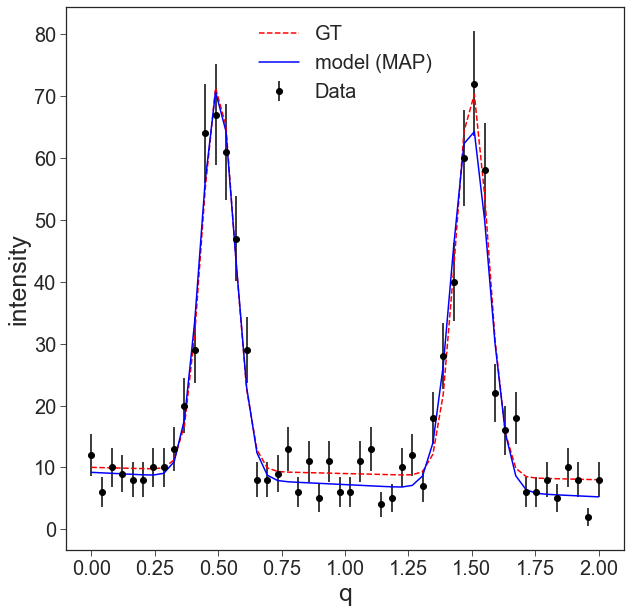

In [4]:
####################################################################################
###### 2) DETERMINE THE "Maximum A Posteriori" (MAP)
####################################################################################
# As a first step we can determine the Maximum A Posteriori (MAP), which
# is similar to a Maximum Likelihood Estimation but finding the maximum
# of the posterior and not the likelihood.
# Remark: If the prior was uniform, the likelihood and posterior would be the 'same'.
MAP_estimate_dict = pm.find_MAP(model=double_peak_model)

# Let's display the parameter values
print("MAP Parameter Estimates:")
print(MAP_estimate_dict)

# Overplot the model for the MAP parameters
plt.figure(figsize=(10, 10))
plt.plot(data_dict['q'], data_dict['y_gt'], 'r--', label='GT')
plt.plot(data_dict['q'], double_peak_model_fn(data_dict['q'], MAP_estimate_dict), 'b-', label='model (MAP)')
plt.errorbar(data_dict['q'], data_dict['y'], data_dict['y_err'], marker='o', ls='', color='k', label='Data')
plt.gca().tick_params(axis='both', labelsize=20)
plt.legend(fontsize=20)
plt.xlabel('q', fontsize=25)
plt.ylabel('intensity', fontsize=25)
plt.show()

# Remarks:
# MAP_estimate_dict also contains 'mu_1_interval__', 'delta_mu_log__' and 'rel_int_1_logodds__' 
# entries. The reason for this is that PyMC3 transforms bounded distributions ('mu_1' has uniform
# prior distribution over [q_min, q_max], 'delta_mu' has half-normal prior distribution over [0, +inf],
# and rel_int_1 has beta prior distribution over [0, 1]) to unbounded distributions using a log-transform. 
# The reason for this is that some sampling schemes (e.g. Hamilton Monte Carlo Sampling) only work on unbounded 
# parameter spaces. PyMC3 will work with the log-transformed variables but will also track the original variables 
# (and will also store their samples during sampling).

In [5]:
#################################################################################################
###### 3) SAMPLE THE POSTERIOR OR LOAD THE PARAMETER SAMPLES (IF IT HAS BEEN SAMPLED ALREADY)
#################################################################################################
# Define the number of steps
num_steps  = 20000
tune_steps = 5000 

# Define the path to the trace files (either store sampled values there or load the trace from these files)
trace_path = 'traces/double_peak_model'

# Should load the trace object -- containing the parameter samples -- (if it exists) or sample the posterior to obtain it?
load_trace = False

# Differ cases if we want to sample the posterior or load it.
# Remark: In both cases we end up with a trace object that contains the parameter samples.
if not load_trace:
    # Sample the posterior and save the results in a 'trace object'
    with double_peak_model:
        # Remarks: 
        # 1) See https://docs.pymc.io/en/v3/api/inference.html for details about the arguments of 'pm.sample'.
        # 2) We use 'start=MAP_estimate_dict' here so that the MAP parameters are used as starting parameter
        #    values for the sampling. For general high dimensional spaces, this might not be a good idea
        #    as discussed in https://discourse.pymc.io/t/about-sampling-start-with-find-map/936.
        #    However, as we removed a potential multimodality due to the two peaks, we believe that our
        #    posterior is unimodal and so starting at the MAP should be fine here.
        trace = pm.sample(num_steps, random_seed=123, chains=3, start=MAP_estimate_dict, init='jitter+adapt_diag', 
                          tune=tune_steps, target_accept=0.9, discard_tuned_samples=False)
    
    print()
    print('Sampling done.')
    print()
    
    # Store the trace in the trace path
    # Remark: Overwrite previous traces if they exist in the trace path
    pm.save_trace(trace, directory=trace_path, overwrite=True)
    print(f"Stored the trace in:\n{trace_path}")

else:
    # Check that the folder exists
    if not os.path.isdir(trace_path):
        err_msg = f"Can not load the trace/posterior-samples.\nThere is no directory in the provided 'trace_path':\n{trace_path}"
        raise FileNotFoundError(err_msg)
    
    # Load the trace from the trace path
    with double_peak_model:
        trace = pm.load_trace(trace_path)
    
    print(f"Loaded the trace from:\n{trace_path}")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 2 jobs)
NUTS: [bg_slope, log10_bg_scale, log10_fwhm_2, log10_fwhm_1, rel_int_1, log10_sum_int, delta_mu, mu_1]
Sampling 3 chains, 0 divergences: 100%|██████████| 75000/75000 [06:28<00:00, 193.12draws/s]



Sampling done.

Stored the trace in:
traces/double_peak_model


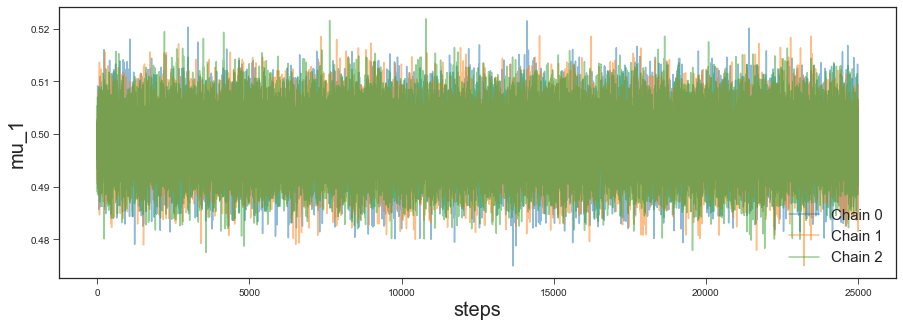

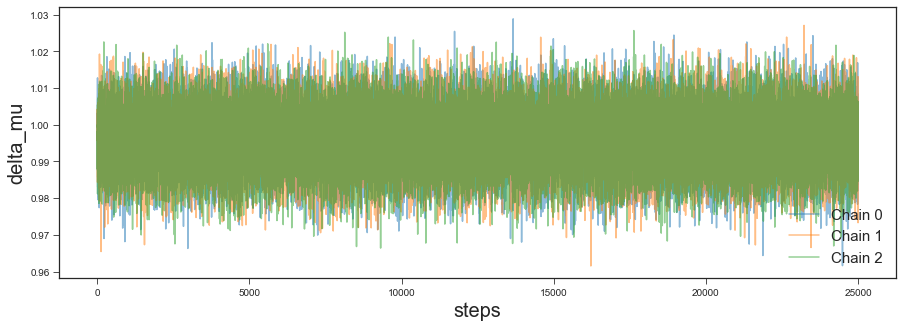

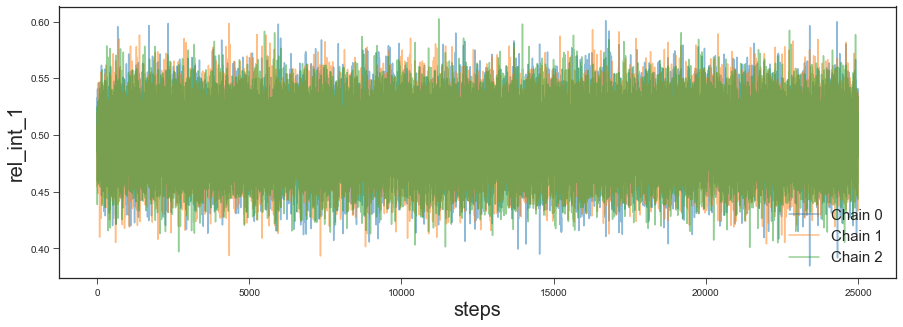

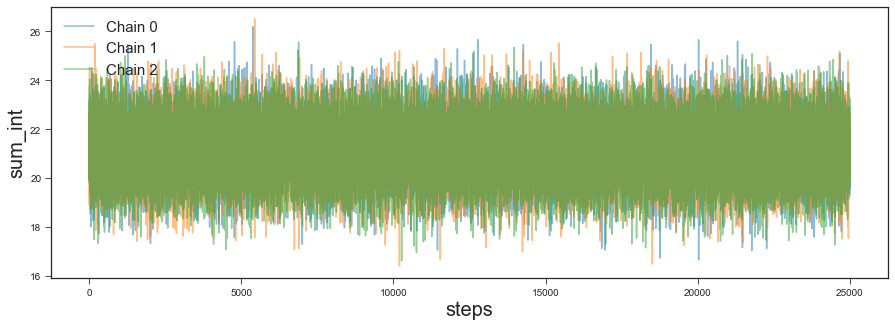

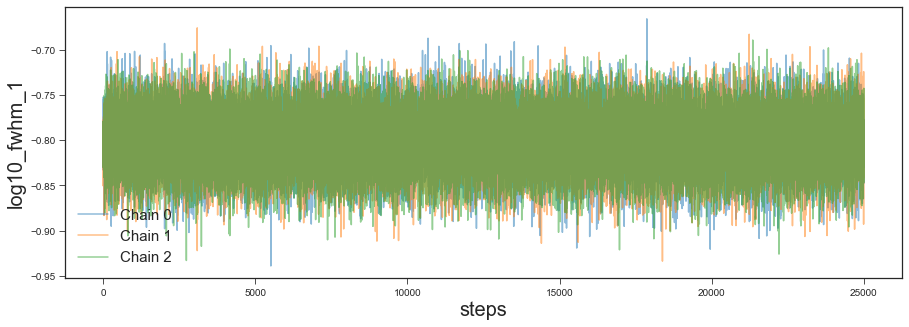

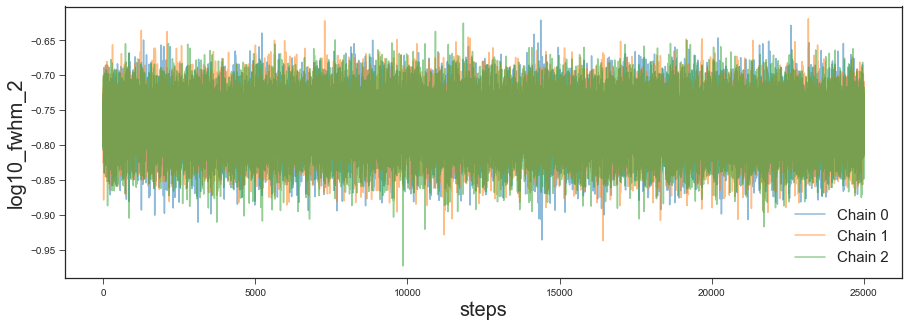

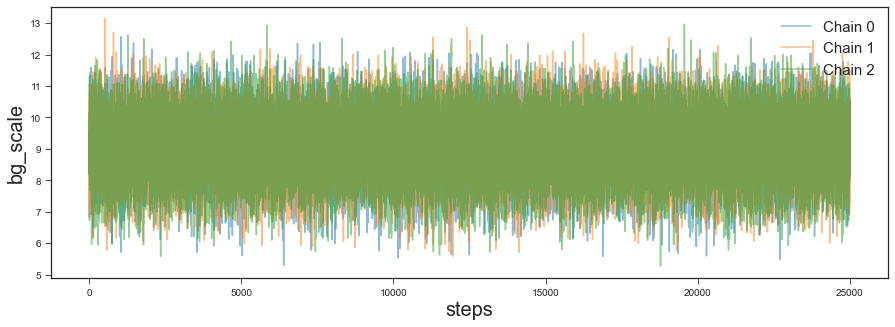

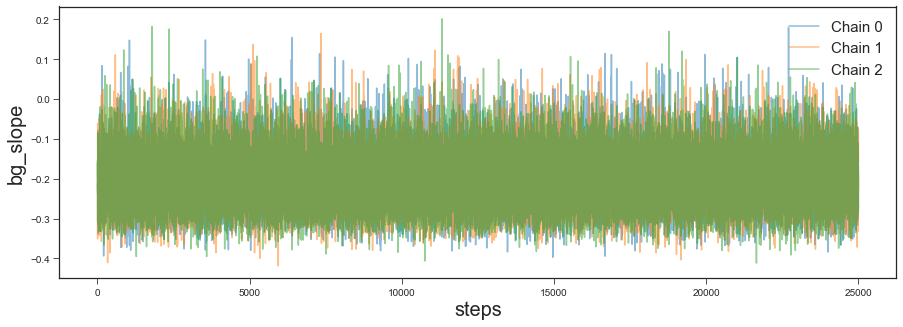

In [6]:
####################################################################################
###### 4) DIAGNOSE SAMPLING TRACES
####################################################################################
reload(utils)

# Remark: The traces of the chains should be checked to assess if the sampling has worked 
#         and also to determine an appropriate number of burnin steps.
utils.plot_trace('mu_1', trace)
utils.plot_trace('delta_mu', trace)
utils.plot_trace('rel_int_1', trace)
utils.plot_trace('sum_int', trace)
utils.plot_trace('log10_fwhm_1', trace)
utils.plot_trace('log10_fwhm_2', trace)
utils.plot_trace('bg_scale', trace)
utils.plot_trace('bg_slope', trace)

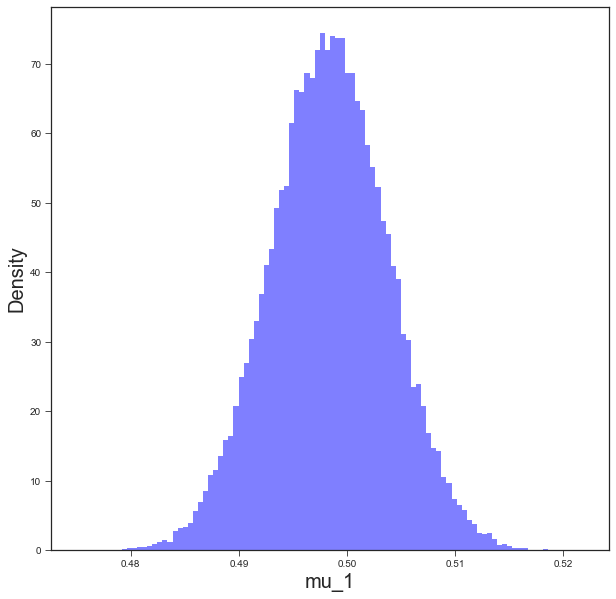

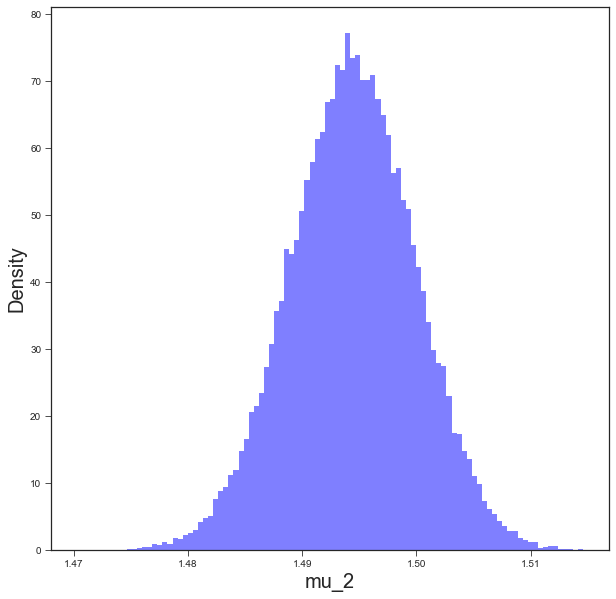

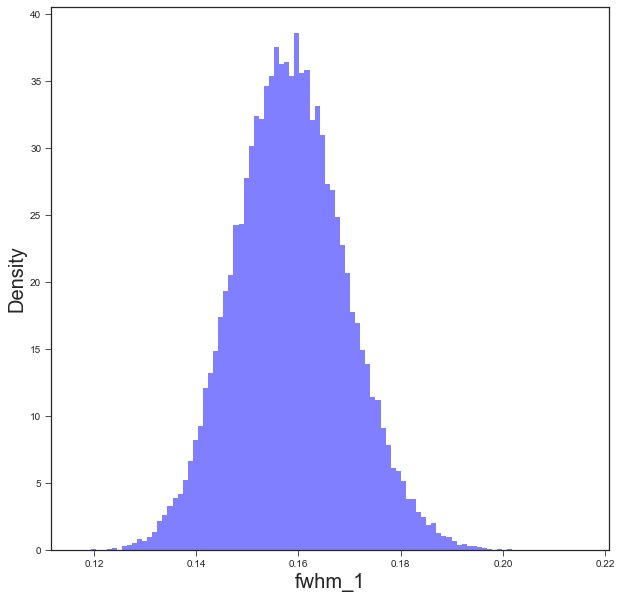

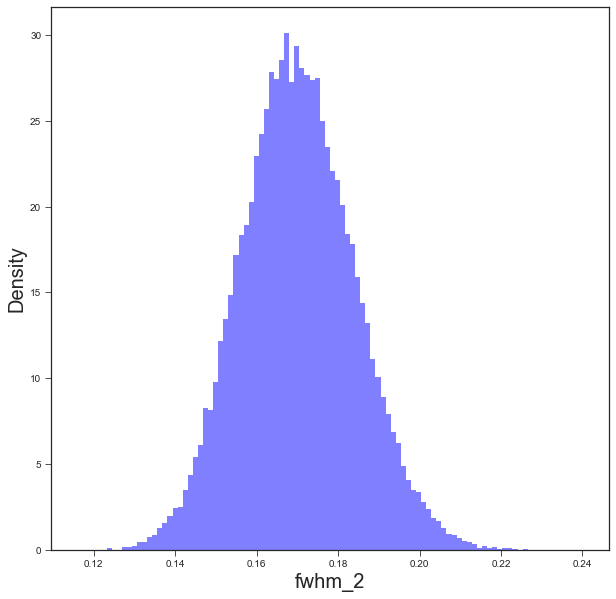

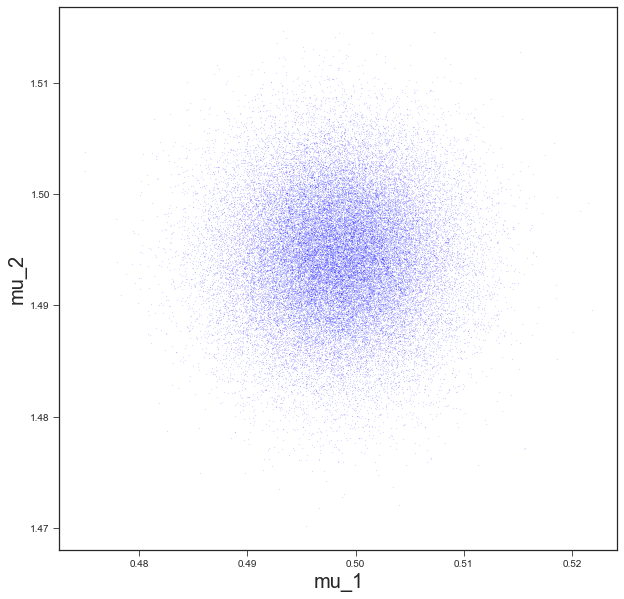

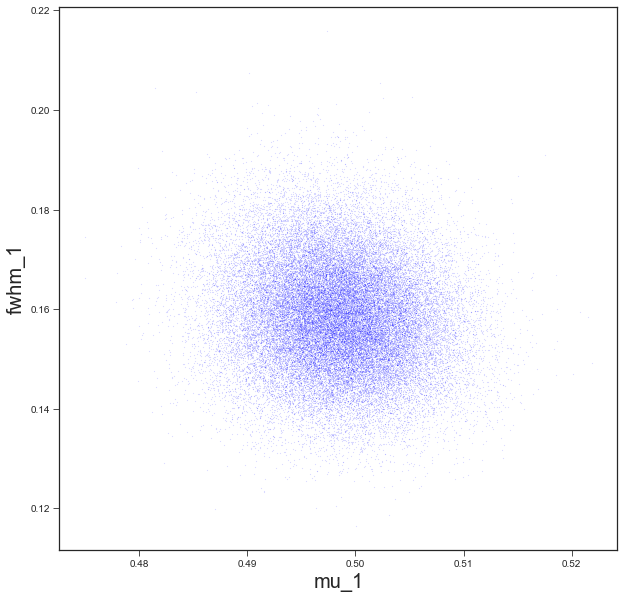

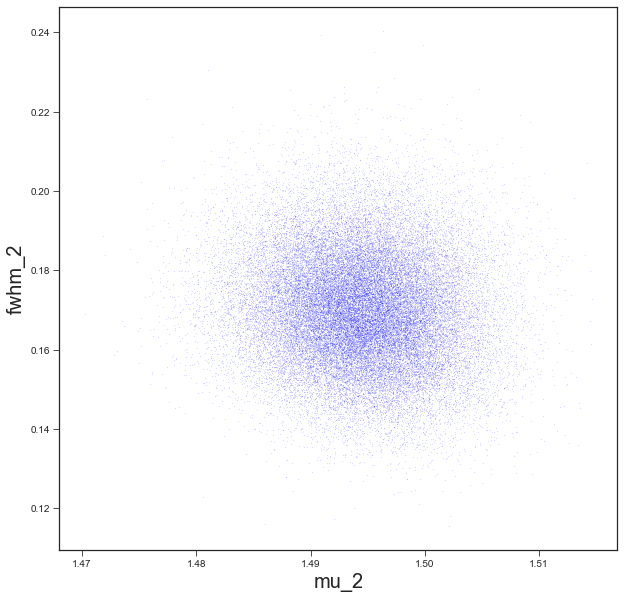

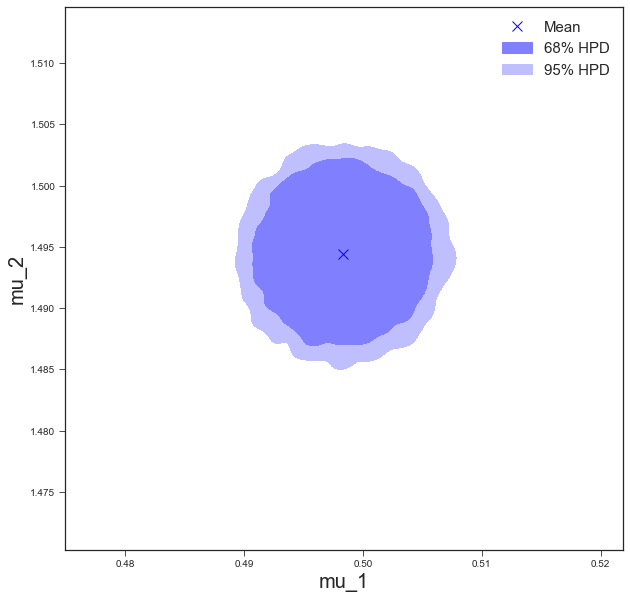

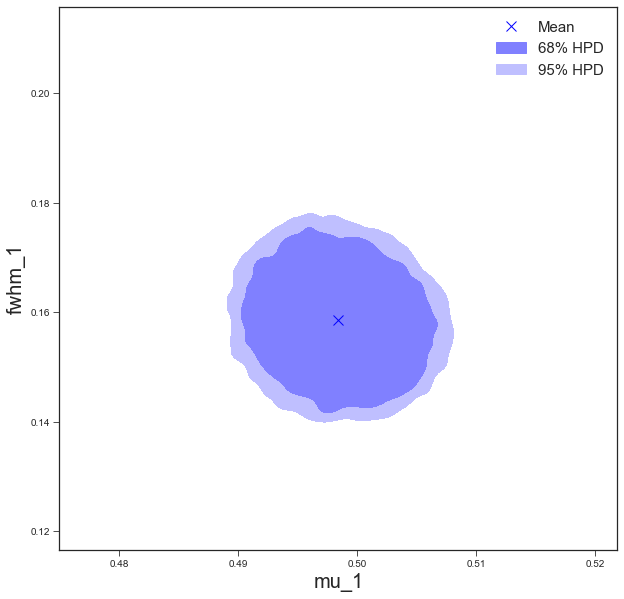

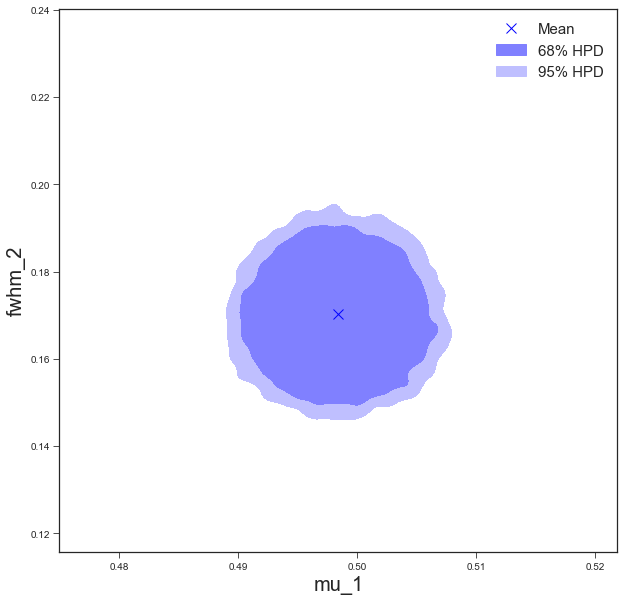

In [7]:
####################################################################################
###### 5) VISUALIZE THE POSTERIOR DISTRIBUTION OF THE PARAMETERS
####################################################################################
reload(utils)

# Remark: We sampled for 20'000 steps of which 5'000 are tuning steps (where the algorithm tunes its own
#         parameters) and 5'000 are burnin steps (where we let the chains equilibrate). Thus we will always
#         discard the first 10'000 (=5'000+5'000) steps in the following.

# Plot the marginals
utils.plot_marginal_posterior('mu_1', trace, discard=10000)
utils.plot_marginal_posterior('mu_2', trace, discard=10000)
utils.plot_marginal_posterior('fwhm_1', trace, discard=10000)
utils.plot_marginal_posterior('fwhm_2', trace, discard=10000)

# Make pair plots (type scatter and type contour)
utils.make_scatter_pair_plot('mu_1', 'mu_2', trace, color='b', discard=10000)
utils.make_scatter_pair_plot('mu_1', 'fwhm_1', trace, color='b', discard=10000)
utils.make_scatter_pair_plot('mu_2', 'fwhm_2', trace, color='b', discard=10000)

# Make pair plots (type contour)
utils.make_contour_pair_plot('mu_1', 'mu_2', trace, color='b', discard=10000)
utils.make_contour_pair_plot('mu_1', 'fwhm_1', trace, color='b', discard=10000)
utils.make_contour_pair_plot('mu_1', 'fwhm_2', trace, color='b', discard=10000)

In [8]:
####################################################################################
###### 6) GET THE PARAMETER ESTIMATES AS SUMMARY STATISTICS
####################################################################################
reload(utils)

# Display the parameter estimates (posterior mean) using 68% Highest Posterior Density 
# (HPD) interval boundaries as errors
utils.display_param_estimate('mu_1', trace, discard=10000, HPD=68)
utils.display_param_estimate('mu_2', trace, discard=10000, HPD=68)

mu_1 = 0.498+0.005-0.005
mu_2 = 1.494+0.006-0.005


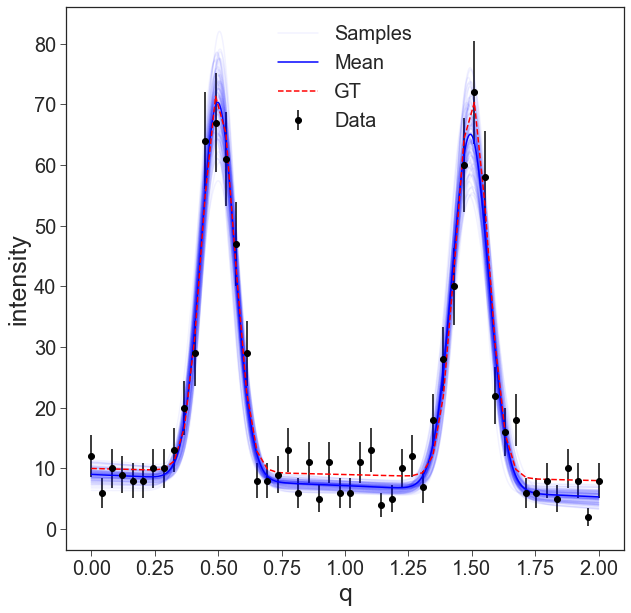

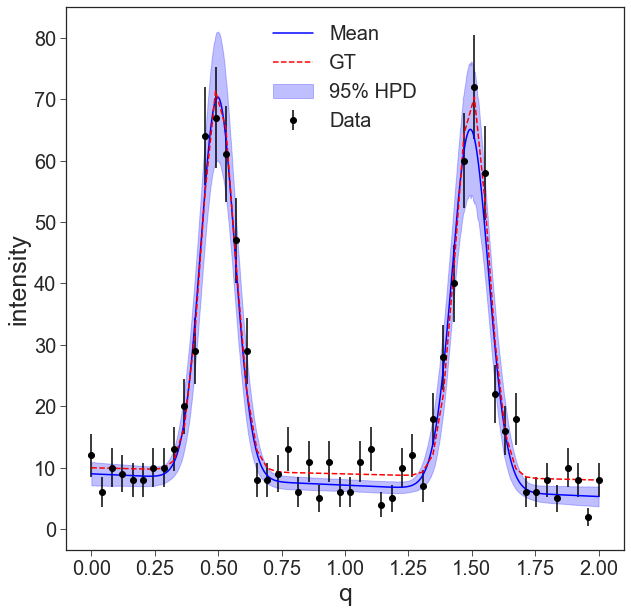

In [12]:
####################################################################################
###### 7) CONSTRUCT THE POSTERIOR DISTRIBUTION OF THE MODEL FUNCTION
####################################################################################
reload(utils)

# Construct the model samples for some q
q_star    = np.linspace(min(data_dict['q']), max(data_dict['q']), 1000)
y_samples = utils.get_model_samples(q_star, trace, discard=10000)

# Determine the mean of the model samples
mean_y    = np.mean(y_samples, axis=0) 

###################################################
### FIGURE TYPE 1
###################################################
plt.figure(figsize=(10, 10))
# Display some model samples
for sample_index, y_sample in enumerate(y_samples[:100]):
    label = None
    if sample_index==0:
        label = 'Samples'
    plt.plot(q_star, y_sample, 'b-', alpha=0.05, label=label)

# Plot the mean of the model posterior
plt.plot(q_star, mean_y, 'b-', label='Mean')

# Plot the ground truth
plt.plot(data_dict['q'], data_dict['y_gt'], 'r--', label='GT')

# Plot the data points
plt.errorbar(data_dict['q'], data_dict['y'], data_dict['y_err'], marker='o', ls='', color='k', label='Data')

# Plot settings
plt.legend(fontsize=20)
plt.gca().tick_params(axis='both', labelsize=20)
plt.xlabel('q', fontsize=25)
plt.ylabel('intensity', fontsize=25)
plt.show()

###################################################
### FIGURE TYPE 2
###################################################
# Get the HPD bounds of the model posterior using 'get_HDD_bounds_vectorial' for each of the samples.
HPD = 95
HPD_bounds_y = utils.get_HDD_bounds_vectorial(y_samples, HDD=HPD)

plt.figure(figsize=(10, 10))
# Display the HPDs as areas
plt.fill_between(q_star, y1=HPD_bounds_y[0], y2=HPD_bounds_y[1], color='b', alpha=0.25, label=f'{HPD}% HPD')

# Plot the mean of the model posterior
plt.plot(q_star, mean_y, 'b-', label='Mean')

# Plot the ground truth
plt.plot(data_dict['q'], data_dict['y_gt'], 'r--', label='GT')

# Plot the data points
plt.errorbar(data_dict['q'], data_dict['y'], data_dict['y_err'], marker='o', ls='', color='k', label='Data')

# Plot settings
plt.legend(fontsize=20)
plt.gca().tick_params(axis='both', labelsize=20)
plt.xlabel('q', fontsize=25)
plt.ylabel('intensity', fontsize=25)
plt.show()